In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import xgboost as xgb
import lightgbm as lgb
import scipy as sp

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# 데이터 가져오기
https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr

In [2]:
data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [3]:
train_df.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.0,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.0,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
test_df.head(3)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930


In [5]:
train_vars = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']

cate_vars = ['zipcode', 'waterfront']

In [6]:
train_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,7517.000000,5.406827e+05,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,4340.374984,3.715247e+05,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,0.000000,7.800000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3758.500000,3.220000e+05,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,7517.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,11275.500000,6.450000e+05,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,15034.000000,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


<br><br><br><br><br><br>

# 1. 데이터 탐색 및 전처리

## 1-1. 결측값 확인

In [7]:
train_df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 1-2. id 중복체크

In [8]:
# id_duplicated = train[train.duplicated(['id'])]
print(len(train_df['id']))
print(len(pd.value_counts(train_df['id'])))

15035
15035


## 1-3. Remove Outlier

In [9]:
out_index = np.array([False] * len(train_df))

out_index = out_index | np.array(train_df['sqft_living'] > 13000)
out_index = out_index | np.array((train_df['price']>2555000) & (train_df['grade'] == 8))
out_index = out_index | np.array((train_df['price']>5555000) & (train_df['grade'] == 11))

In [10]:
# train_df = train_df.loc[out_index == False]

## 1-4. Additional Variables

In [11]:
for df in [train_df, test_df]:
    df['conv_date'] = [1 if values[:4] == '2014' else 0 for values in df.date ]
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    df['sqft_total_size'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement']
    df['sqft_total15'] = df['sqft_living15'] + df['sqft_lot15'] 
    
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x <= 0 else 1)

## 1-5. Display Variables

In [12]:
def display_var(var_i, df):
    df[df.columns[var_i]].value_counts().plot(kind='bar')
    plt.title(var_i)
    plt.xlabel(df.columns[var_i])
    plt.ylabel('Count')
    plt.show()

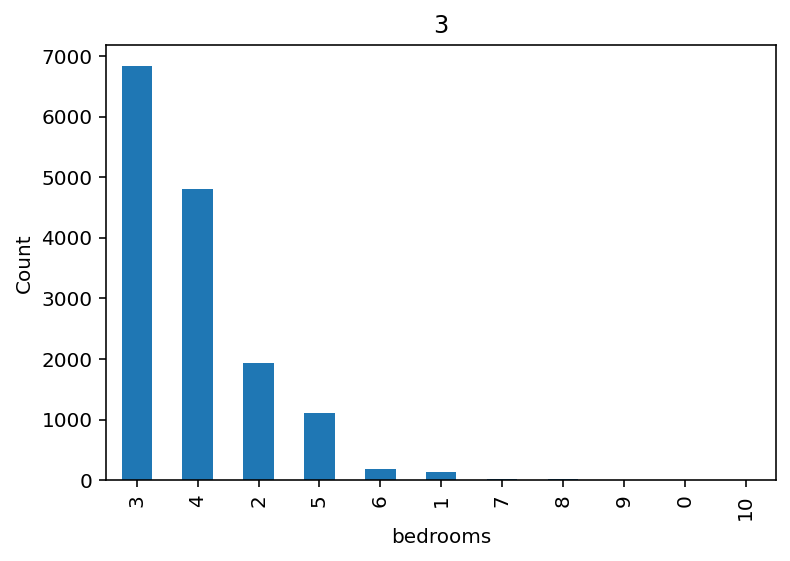

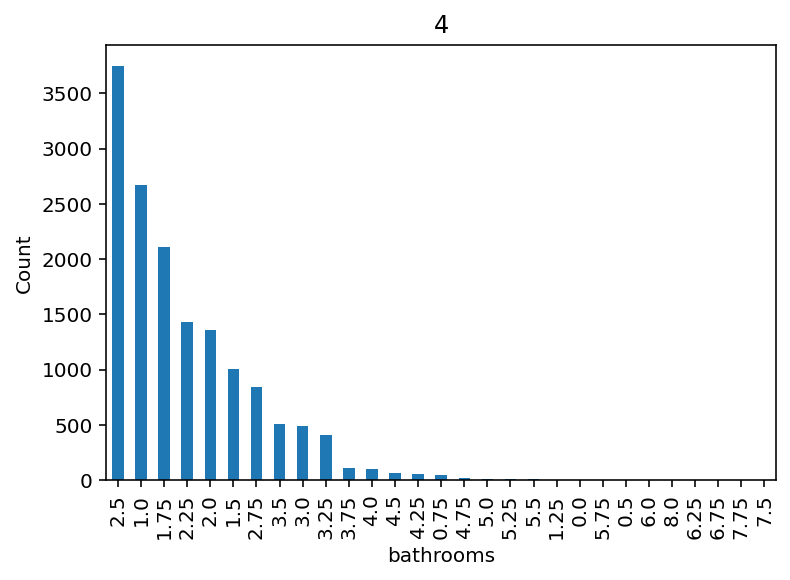

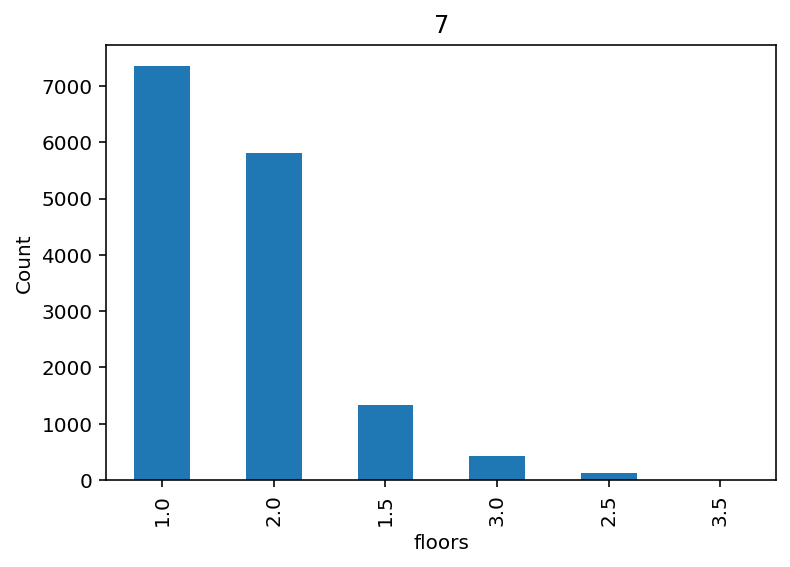

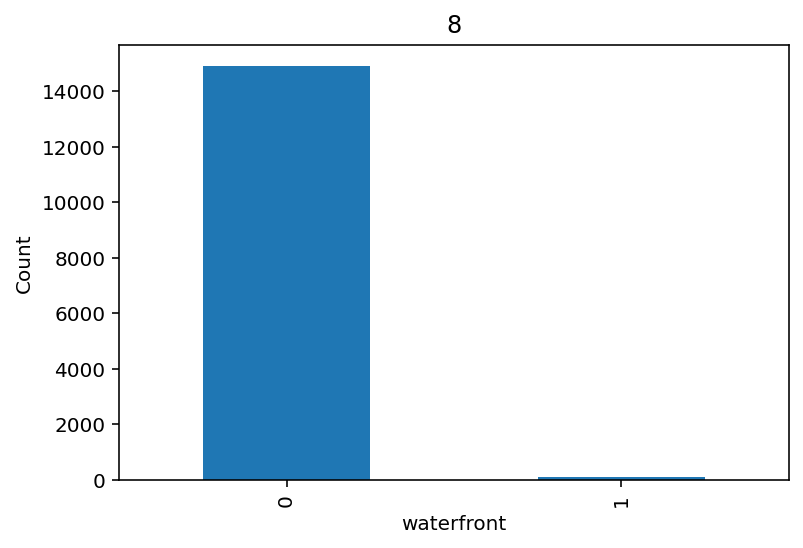

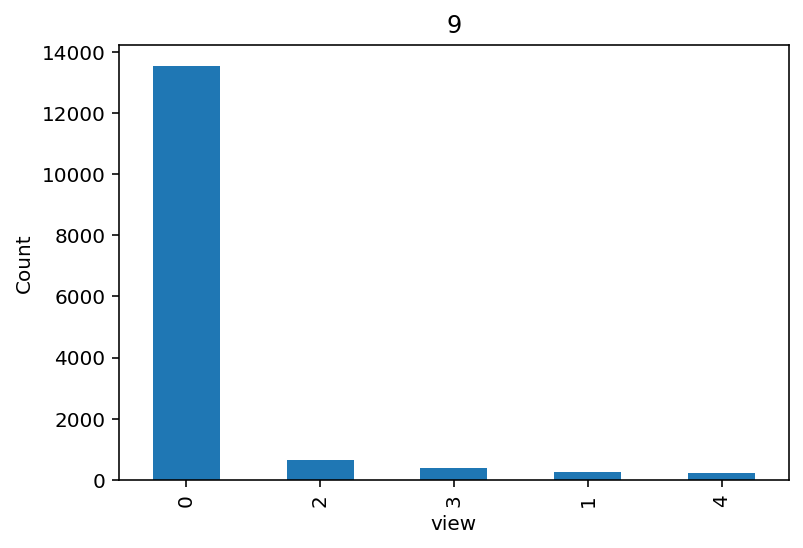

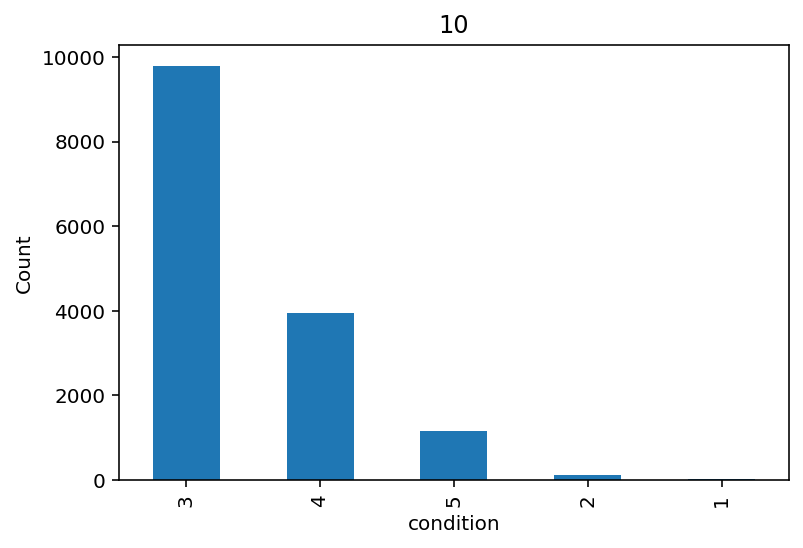

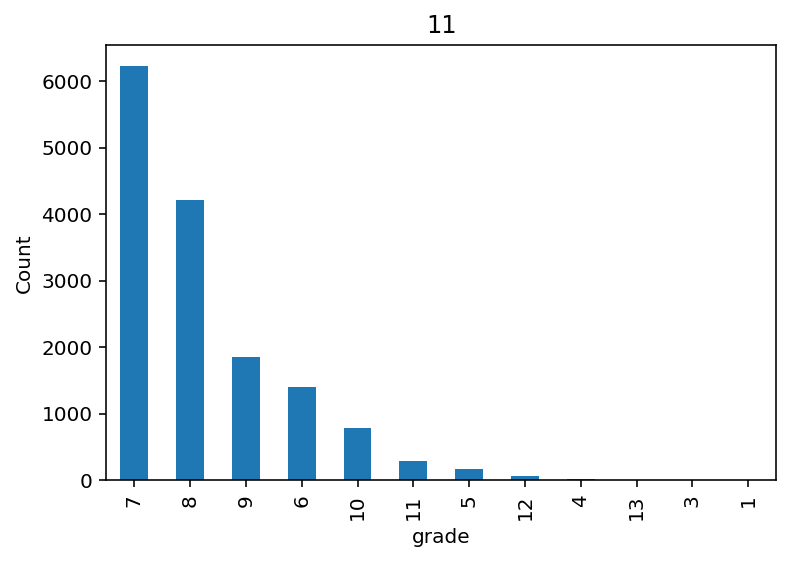

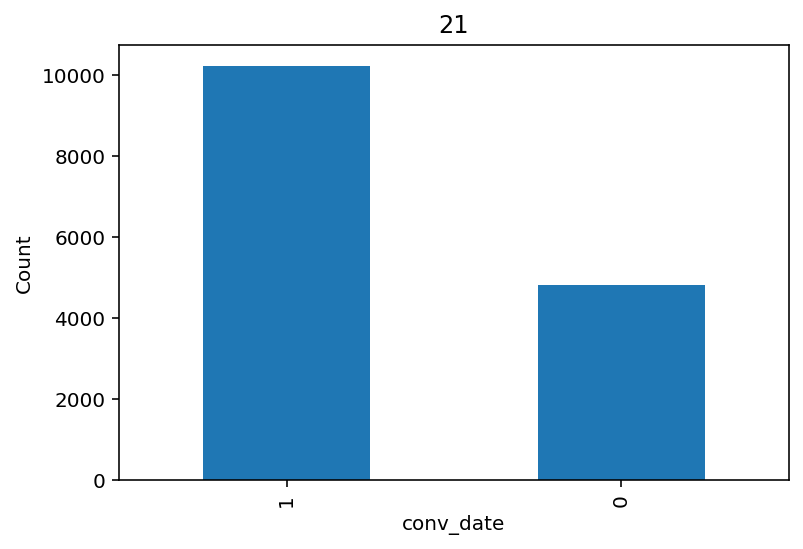

In [13]:
display_var(3, train_df)
display_var(4, train_df)
display_var(7, train_df)
display_var(8, train_df)
display_var(9, train_df)
display_var(10, train_df)
display_var(11, train_df)
display_var(21, train_df)

## 1-6. Normalization Variables

In [14]:
skew_columns = ['sqft_ratio', 'sqft_total_size', 'sqft_total15', 'sqft_above', 'sqft_basement','sqft_living','sqft_lot','sqft_living15', 'sqft_lot15']

minimax_columns = ['lat', 'long', 'total_rooms', 'view', 'condition', 'grade', 'bedrooms', 'bathrooms', 'floors',
                   'sqft_ratio', 'sqft_total_size', 'sqft_total15', 'sqft_above', 'sqft_basement','sqft_living','sqft_lot','sqft_living15', 'sqft_lot15']

etc_vars = ['id', 'date']

In [15]:
for c in skew_columns:
    train_df[c] = np.log1p(train_df[c].values)
    test_df[c] = np.log1p(test_df[c].values)

In [16]:
train_df['price'] = np.log1p(train_df['price'].values)

In [17]:
from sklearn.preprocessing import minmax_scale

In [18]:
concat_df = pd.concat([train_df, test_df], axis=0, sort=False)
for col in minimax_columns:
    col_name = col
    norm_value = minmax_scale(concat_df[col_name])
    train_df[col_name] = norm_value[:len(train_df)]
    test_df[col_name] = norm_value[len(train_df):]

# 2. DataSET Split

In [19]:
from sklearn.model_selection import train_test_split

def sep_target(df, target_vars):
    return df.drop(target_vars, axis=1), df[target_vars]
def col_trim(df, remove_cols):
    return df.drop(remove_cols, axis=1)


target_vars = ['price']
trn_df, trn_y = sep_target(train_df, target_vars)
trn_df = col_trim(trn_df, etc_vars)
tst_df = col_trim(test_df, etc_vars)

In [31]:
len(trn_df.columns)

24

In [29]:
len(tst_df.columns)

24

In [33]:
trn_y

,price
0,12.309987
1,12.100718
2,13.142168
3,12.458779
4,12.583999
...,...
15030,13.322338
15031,13.822984
15032,12.793862
15033,12.899222


In [34]:
# x_train, x_valid, y_train, y_valid = train_test_split(x_train_norm, y_train, test_size=0.3, random_state=25)
# trn_x_full, val_x_full , trn_y_full, val_y_full = train_test_split(trn_df, trn_y, test_size = 0, random_state = 9109)
# trn_x, val_x , trn_y, val_y = train_test_split(trn_df, trn_y, test_size = 0.2, random_state = 9109)

In [ ]:
trn_y_v, val_y_v = map(np.ravel, [trn_y.values, val_y.values])
trn_y_full_v, val_y_full_v = map(np.ravel, [trn_y_full.values, val_y_full.values])

In [ ]:
np.shape(np.ravel(trn_y_v))

In [ ]:
train_vars = tst_df.columns

<br><br><br><br><br><br><br><br>

# 2. 모델별 스코어

## 2-1. RMSE
기존에 y를 로그함수로 변환해주었기 때문에 mean_squared_error에 값을 넘기기 전,  
np.expm1으로 다시 변환해서 넘겨준다.

In [35]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

## 2-2. 모델별 학습 및 예측

In [36]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        # 모델이름 획득
        model_name = model.__class__.__name__
        # train, test 데이터셋 분리 - 여기에도 random_state를 고정
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        # 학습
        model.fit(X_train, y_train)
        # 예측
        y_pred = model.predict(X_test)
        # 예측결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

## Model
- random_state
  - 모델 초기화나 데이터셋 구성에 사용되는 랜덤 시드값
  - 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택
  - None일 때, 파라미터 초기화나 데이터셋 구성 양상이 달라져 모델과 데이터셋이 동일하더라도 머신러닝 학습결과는 학습할 때마다 달라진다.
  - 어떤 시도가 모델 성능향상에 긍정적이였는지 판단하기 위해 랜덤적 요소의 변화때문에 생기는 불확실성을 제거해야 한다.
  - 따라서 특정값으로 고정시켜준다.

In [40]:
random_state = 2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

get_scores(models, trn_df, trn_y)

,RMSE
GradientBoostingRegressor,127548.043663
RandomForestRegressor,125788.535838
XGBRegressor,115078.543738
LGBMRegressor,113675.724961


<br><br><br><br><br><br><br><br>

# 3. 하이퍼파라미터 탐색

## 3-1. 그리드 탐색
**GridSearchCV 사용 (Grid Search)**
- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [37]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model,
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              cv=5,
                              verbose=verbose,
                              n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']          # 각 파라미터에 대한 조합
    score = grid_model.cv_results_['mean_test_score']  # 각 조합에 대한 점수

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])  # rmse: 평균제곱근오차
    results = results.rename(columns={'RMSE': 'RMSLE'})
    results = results.sort_values('RMSLE')  # `RMSLE`가 낮은 순서대로 정렬

    return results

- 각 파라미터에 대한 조합마다의 점수를 나타냄
- 왜 음수일까?  
  - scoring : 'neg_mean_squared_error'
  - neg_mean_squared_error : 평균 제곱 오차의 반댓값(음수)을 계산
  - 점수가 올라가면 좋다! (즉, 돈을 적게 잃어야 하는 것과 같다)

In [42]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [-1],
    'learning_rate': [0.005],
    'num_iteration': [10000],
    'num_leaves': [30],
    'min_data_in_leaf': [20],
    'feature_fraction': [0.8],
    'boosting': ['gbdt'],
    'objective':['regression'],
    'num_boost_round':[5000],
    'metric':['rmse'],
    'reg_alpha': [0],
    'reg_lambda': [10]
}

model = LGBMRegressor(random_state=random_state)

my_GridSearch(model, trn_df, trn_y, param_grid, verbose=2, n_jobs=5)
# 0.158893

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    9.4s remaining:   14.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   17.1s finished


[LightGBM] [Warning] num_iterations is set with num_boost_round=5000, will be overridden by num_iteration=10000. Current value: num_iterations=10000
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] num_iterations is set=10000, num_iteration=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


,boosting,feature_fraction,learning_rate,max_depth,metric,min_data_in_leaf,n_estimators,num_boost_round,num_iteration,num_leaves,objective,reg_alpha,reg_lambda,score,RMSLE
0,gbdt,0.8,0.005,-1,rmse,20,100,5000,10000,30,regression,0,10,-0.025762,0.160504


<br><br><br><br><br><br><br><br>

# 4. 학습 및 예측 결과 생성

위에서 max_depth = 10, n_estimators=100이 가장 좋은 조합으로 나왔다.

In [43]:
param_grid = {
    'n_estimators': 100,
    'max_depth': -1,
    'learning_rate': 0.005,
    'num_iteration': 10000,
    'num_leaves': 30,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'boosting': 'gbdt',
    'objective':'regression',
    'num_boost_round':5000,
    'metric':'rmse'
}

model_lgb = LGBMRegressor(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.005,
    num_iteration=10000,
    num_leaves=30,
    min_data_in_leaf=20,
    feature_fraction=0.8,
    boosting='gbdt',
    objective='regression',
    num_boost_round=5000,
    metric='rmse',
    random_state=random_state)

#    early_stopping_rounds=100

<br><br><br><br><br><br><br><br>

# 5. csv에 쓰기

In [44]:
def save_submission(model, train, y, test, model_name, rmsle):
    # 위에 나온 결과로 학습 및 예측 결과 생성
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)  # 원래 스케일로 되돌림
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    
    # csv에 쓰기
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [45]:
save_submission(model, trn_df, trn_y, tst_df, 'lgbm', rmsle='0.160504')

/home/ssac14/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.160504.csv saved!


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_norm, y_train, test_size=0.3, random_state=25)
model.fit(x_train, y_train, epochs=n_train_epoch, validation_data=(x_valid, y_valid), batch_size=100)
